<a href="https://colab.research.google.com/github/andrepaulodantas/python/blob/main/Bitcoin_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Programa Desenvolvido para Previsão do Preço de Fechamento do Bitcoin
### Bibliotecas Utilizadas:


*   Pandas
*   Numpy
*   Scikit-Learning
*   StatsModel
*   Pytorch



In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive') # Parâmetros Luiz Phillip Não apagar

Mounted at /content/MyDrive


In [ ]:
import os
path = '/content/MyDrive/MyDrive/Bitcoin Forecast' # Parâmetros Luiz Phillip Não apagar
os.chdir(path)

In [ ]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5MB 6.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
!pip install mplfinance

     |████████████████████████████████| 61kB 3.0MB/s 


### Bibliotecas para Visualização

In [ ]:
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import mplfinance as mpf
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mtp

In [ ]:
df = pd.read_csv('dados_bitcoin.csv', index_col = 'Date', parse_dates=['Date'])
df.sample(5)

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-20,11656.200195,13103.000000,11656.200195,12899.200195,1.180170e+10
2019-08-14,10889.487305,10889.556641,10028.135742,10051.704102,1.999084e+10
2019-05-09,5982.316406,6183.039063,5982.316406,6174.528809,1.678465e+10
2020-12-07,19343.128906,19411.828125,18931.142578,19191.630859,2.689636e+10
2016-03-07,407.756989,415.916992,406.308990,414.321014,8.576240e+07


### Comportamento Histórico do Bitcoin entre Fevereiro de 2016 e Fevereiro de 2021

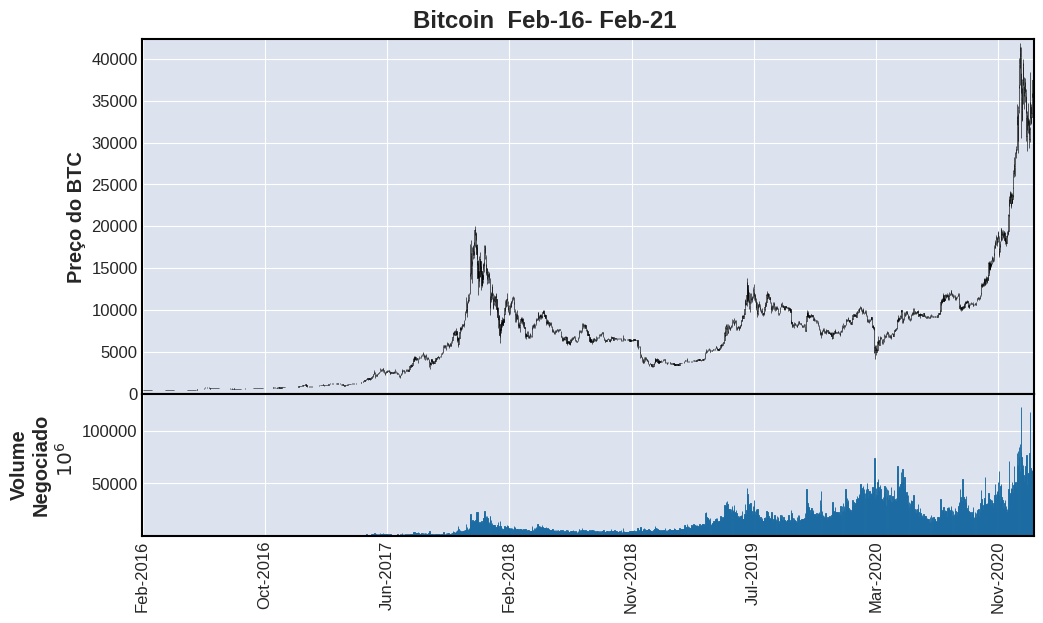

In [ ]:
mpf.plot(df,type='candle',volume=True,figratio=(25,14), datetime_format='%b-%Y',xrotation=90,tight_layout=True, title = f'Bitcoin {df.index[0]: %b-%y}-{df.index[-1]: %b-%y}\n \n', ylabel = 'Preço do BTC', ylabel_lower='Volume\nNegociado')

### Correlação entre Variáveis e Histogramas

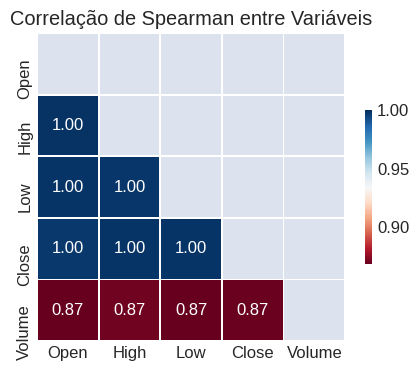

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


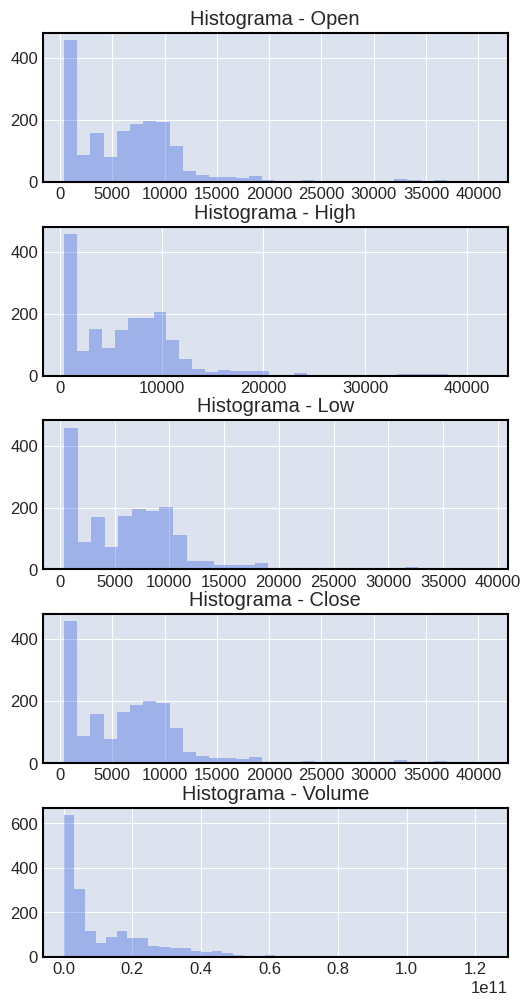

In [ ]:
corr = df.corr(method = 'spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap = 'RdBu', vmax = 1,
            square=True, linewidths=.5, annot = True, fmt = '.2f', cbar_kws={"shrink": .5})
ax.set(title = 'Correlação de Spearman entre Variáveis')
plt.show()
fig, ax = plt.subplots(5,1, figsize = (6, 12))
plt.subplots_adjust(hspace=0.3)
for a, var in tuple(zip(ax, df.columns)):
  sns.distplot(df[var], color = 'royalblue', kde = False, ax = a)
  a.set(title = f'Histograma - {var}')
  a.set_xlabel('')
plt.show()

## Primeiro Modelo - ARIMA:
*    Modelo Linear composto de três componentes, auto-regressivo (AR), média móvel (MA) e integrado (D);
*    $$AR(p) := \sum_{i=1}^{p} \alpha_{i}x_{t-i} + \epsilon(t)$$
*    $$MA(q) := \sum_{i=1}^{p} \theta_{i}\epsilon_{t-i} + \epsilon(t)$$
* O termo integrado consiste de uma diferenciação na série para que a série temporal seja estacionária;
* $$ARIMA(p,d,q) = AR(p) + MA(q)$$

O primeiro passo consistirá então de verificar se o preço de fechamento é estacionário ou não. Em caso negativo, diferencioções sucetivas serão aplicadas na série até atingir a estacionariedade;

In [ ]:
dick = adfuller(df.Close.values.ravel())
print(f'Valor do Teste: {dick[0]: .2f} - P Valor: {dick[1]: .4f}')

Valor do Teste:  2.30 - P Valor:  0.9990


Pelo Teste de Dickey-Fuller não há motivos para se rejeitar a hipótese nula de não estacionaridade da série. Desta forma, uma diferenciação será feita.

In [ ]:
dick = adfuller(df.Close.diff().dropna().values.ravel())
print(f'Valor do Teste: {dick[0]: .2f} - P Valor: {dick[1]: .2e}')

Valor do Teste: -8.49 - P Valor:  1.34e-13


Com uma diferenciação foi possível tornar a série estacionária. Sendo assim, temos o primeiro parâmetro do modelo definido $(d = 1)$;

O próximo passo consiste da utilização da autocorrelação e da autocorrelação parcial para determinar a quantidade de termos passados de sinais de ruído e valores de fechamento passados respectivamente.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  


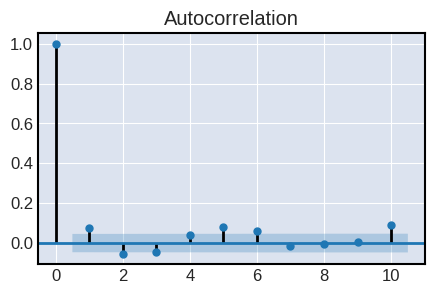

In [ ]:
fig, ax = plt.subplots(figsize = (5, 3))
plot_acf(df.Close.diff().dropna().values.ravel(), lags=10, unbiased=True, fft = True, ax = ax)
plt.show()

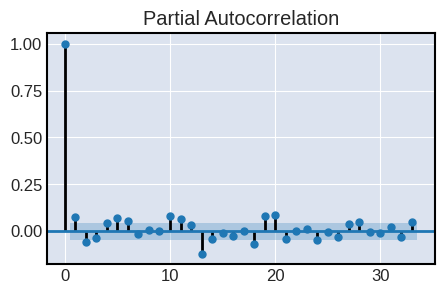

In [ ]:
fig, ax = plt.subplots(figsize = (5, 3))
plot_pacf(df.Close.diff().dropna().values.ravel(), ax = ax)
plt.show()

Pelos gráficos de PACF e ACF podemos utilizar ambos os termos iguais a 1. Sendo assim temos um modelo do tipo:
* $$ARIMA(p=1,d=1,q=1)$$

O próximo passo consiste em aplicar esse modelo a série temporal e verificar sua performance.

O conjunto de treino para todos os modelos consiste dos dados históricos entre 06-fev-2016 e 02-fev-2020 (1.458 pontos), o conjutno de teste será formado pelos dados entre 03-fev-2020 e 05-fev-2021 (365 pontos). Foi definido desta forma utilizando a estratégia 80-20. No caso dos modelos de Redes Neurais será retirada uma parte dos dados de treino para ser utilizada em estratégias de parada.

Obs: Ao final serão apresentados os resultados de todos os modelos gráficamente e através das métricas definidas.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
amount_data_for_train = int(0.8*df.shape[0])
train_data = df.Close[:amount_data_for_train]
test_data = df.Close[amount_data_for_train:]
train, test = amount_data_for_train, test_data.shape[0]
history = [x for x in train_data]
predictions_arima = list()

model_2 = ARIMA(train_data, order=(1,1,1), freq='D')
model_fit_2 = model_2.fit()
pred_without_retrain = model_fit_2.forecast(len(test_data), typ = 'levels', dinamic = True)

for t in range(test):
	model = ARIMA(history[t:], order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions_arima.append(yhat)
	obs = test_data[t]
	history.append(obs)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
def mape(y_true: np.ndarray, y_pred: np.ndarray):
  return np.mean(np.abs(y_pred - y_true)/y_true)

In [ ]:
def plot_test(predictions: np.ndarray, true_value: pd.core.frame.DataFrame, model_name: str):
  mape_model = mape(true_value.values.ravel(), predictions)
  fig, ax = plt.subplots(figsize = (15, 6))
  ax.plot(true_value, color = 'royalblue', lw = 3, label = 'Valor Real')
  ax.plot(true_value.index, predictions, color = 'indianred', ls = '--', label = 'Valor Predito')
  ax.set_title(f'MODELO {model_name} - MAPE: {mape_model: .2%}')
  date_form = DateFormatter("%d-%b-%Y")
  date_form = DateFormatter("%d-%b-%Y")
  ax.xaxis.set_major_formatter(date_form)
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
  ax.set_ylabel('Preço de Fechamento do Bitcoin')
  plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
  ax.legend()
  plt.show()

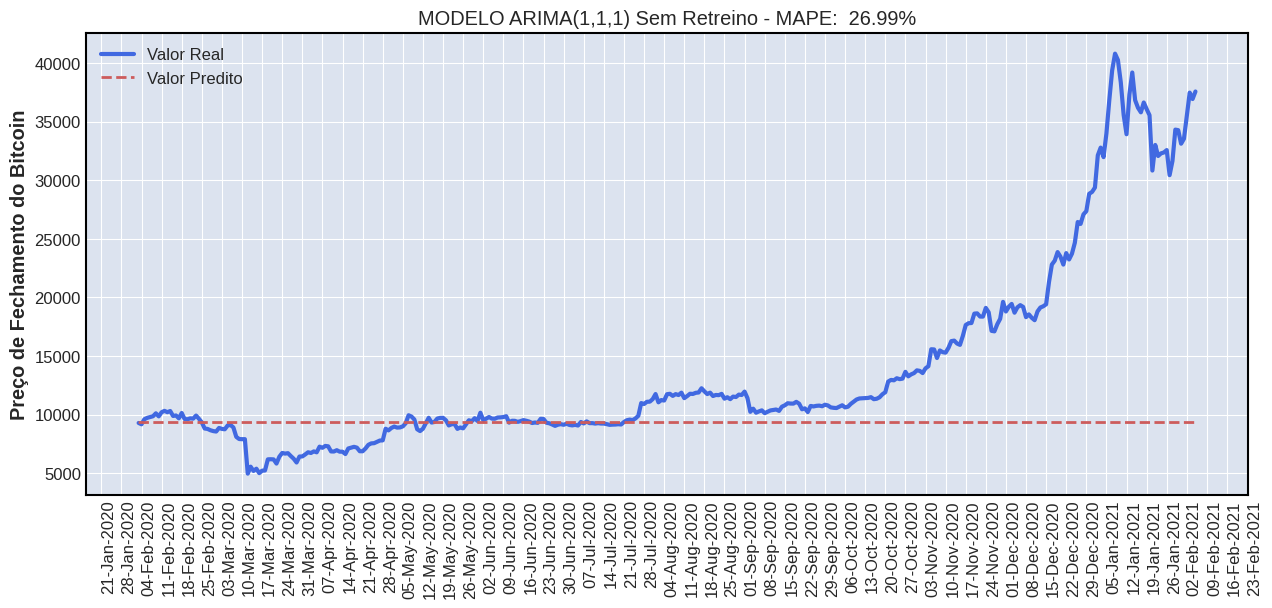

In [ ]:
plot_test(pred_without_retrain.values.ravel(), test_data, 'ARIMA(1,1,1) Sem Retreino')

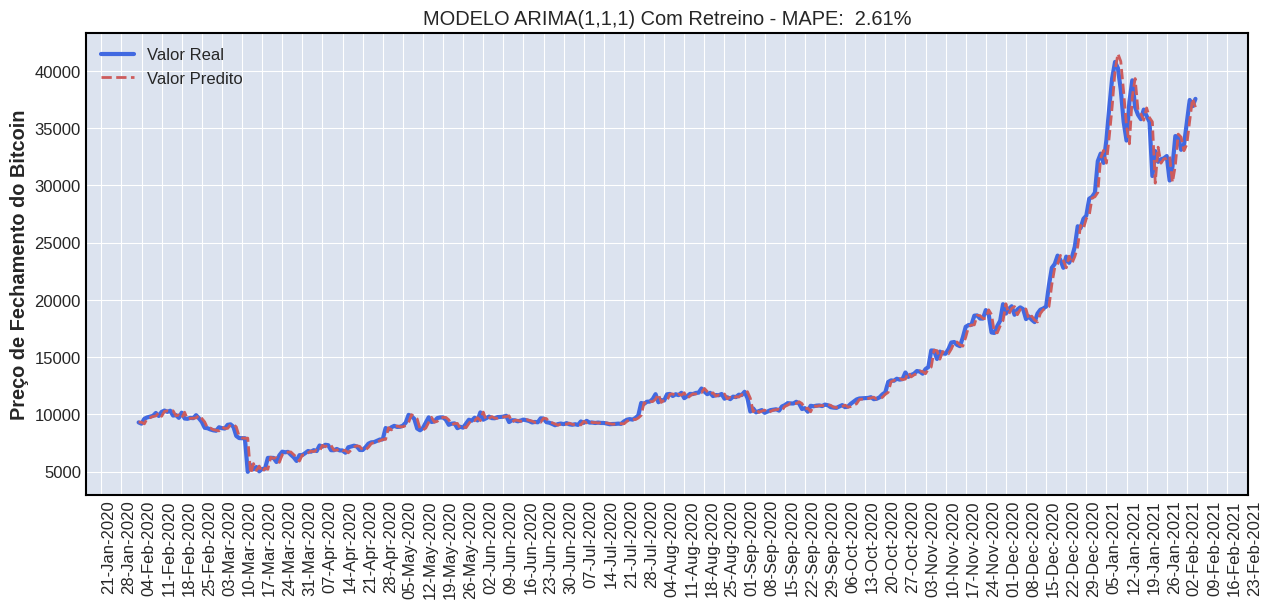

In [ ]:
plot_test(predictions_arima, test_data, 'ARIMA(1,1,1) Com Retreino')

Conclusões:

Utilizando o ARIMA com retreinos foi possível obter um modelo satisfatório para o problema. O modelo utiliza o valor do dia anterior e o ruído do dia anterior para prever o valor do dia atual. Entretanto, para obter um resultado satisfatório foi necessário contruir o modelo, realizar a previsão e ao final do dia retreinar o modelo. Na prática não há problemas nisso, porém não é algo desejável.

### Segundo Modelo - Long Short Term Memory (LSTM)
*  Modelo baseado em redes neurais recorrentes (RNN)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            self.early_stop = False

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
class MinMaxScalerVectorized(object):
    """MinMax Scaler

    Transforms each channel to the range [a, b].

    Parameters
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    
    def fit(self, tensor):
        self._maximum_value = tensor.max(dim=0, keepdim=True)[0]
        self._minimun_value  = tensor.min(dim=0, keepdim=True)[0]
        self._lenght = self._maximum_value - self._minimun_value
        self._lenght[self._lenght == 0] = 1
        self._scale = 1/self._lenght
        return self
    
    def inverse_transform(self, tensor):
        features = tensor.detach().clone()
        a, b = self.feature_range
        inverse = 1/(b-a)
        features = features.sub_(a).mul_(inverse)
        features = features.mul_(1/self._scale).add_(self._minimun_value)
        return features.type(torch.float)


    def __call__(self, tensor):
        """Transform features

        Parameters
        ----------
        stacked_features : tuple, list
            List of stacked features.

        Returns
        -------
        tensor 
            A tensor with scaled features using requested preprocessor.
        """
        features = tensor.detach().clone()

        # Feature range
        a, b = self.feature_range
        features = features.sub_(self._minimun_value).mul_(self._scale)
        features = features.mul_(b - a).add_(a)

        return features.type(torch.float)

In [ ]:
training_set = df.Close.values
dados  = torch.tensor(training_set)
datos = dados.squeeze(-1)
datos = dados.type(torch.float) 
print(dados.shape)

torch.Size([1823])


In [ ]:
def Window(data, lenght_windows):
  lenght_data = data.shape[0]
  data_x = torch.zeros(lenght_data - lenght_windows, lenght_windows)
  data_y = torch.zeros(lenght_data - lenght_windows)
  for i in range(lenght_windows):
    data_x[:,i] = data[i:lenght_data - lenght_windows + i] 
  data_y = data[lenght_windows:].unsqueeze(-1)
  return data_x.unsqueeze(-1), data_y

In [ ]:
train_size = amount_data_for_train
test_size = len(dados) - train_size

# seq_length = 4 #Best Choice
seq_length = 3
x, y = Window(dados, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
trainX, trainY = x[:train_size], y[:train_size]
testX, testY   = x[train_size:], y[train_size:]

scaler_model_input = MinMaxScalerVectorized(feature_range = (0, 1))
scaler_model_output = MinMaxScalerVectorized(feature_range = (0, 1))
scaler_model_input.fit(trainX)
scaler_model_output.fit(trainY)
trainX_scale = scaler_model_input(trainX)
trainY_scale = scaler_model_output(trainY)
testX_scale  = scaler_model_input(testX)
testY_scale  = scaler_model_output(testY)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.seq = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                nn.Tanh(),
                                nn.BatchNorm1d(hidden_size),
                                nn.Linear(hidden_size, 1))

    def forward(self, x):
        # h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        ula, (h_out, _) = self.lstm(x)
        h_out = h_out.view(-1, self.hidden_size)
        out = self.seq(h_out)
        return out

In [ ]:
def print_epoch(epoch, train_loss, validate_loss):
  print(f"Epoch: {epoch}, Loss Train: {train_loss: .5f}, Loss Val: {validate_loss: .5f}")

def train(model, optmizer, loss_f, num_epochs, tensor_train, val_x = None, val_y = None, patience = 5, use_early_stopping = False):
  train_losses = []
  loss_batch = []
  valid_losses = []
  if use_early_stopping:
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    for epoch in range(num_epochs):
      model.train()
      for data_train_x, data_train_y in tensor_train:
        optimizer.zero_grad()
        outputs = model(data_train_x)
        loss = loss_f(outputs, data_train_y)
        loss.backward()
        optimizer.step()
        loss_batch.append(loss.item())
      train_losses.append(np.mean(loss_batch))
      loss_batch = []
      model.eval()
      pred_val = model(val_x)
      val_loss = loss_f(pred_val, val_y)
      valid_losses.append(val_loss.item())
      if epoch % 25 == 0:
        early_stopping(val_loss.item(), model)
      if epoch % 100 == 0:
        print_epoch(epoch, loss.item(), val_loss.item())
      if early_stopping.early_stop and epoch > 500:
        print("Early stopping")
        break
    model.load_state_dict(torch.load('checkpoint.pt'))
  else:
    for epoch in range(num_epochs):
      data_train_x, data_train_y = tensor_train.dataset.tensors
      model.train()
      optimizer.zero_grad()
      outputs = model(data_train_x)
      loss = loss_f(outputs, data_train_y)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      if epoch % 100 == 0:
        print_epoch(epoch, loss.item(), 0)
    
  
  return model, train_losses, valid_losses


In [ ]:
# Hiperparametros
validate_size = 0.1
np.random.seed(42)
idx = np.arange(0, amount_data_for_train-3)
idx_train = np.random.choice(idx, size=int((1-validate_size)*amount_data_for_train), replace=False)
idx_val = idx[~np.isin(idx, idx_train)]

num_epochs = 1000
learning_rate = 0.01


input_size = 1
hidden_size = 4
num_layers = 1
batch_size = 32

# data_train = torch.utils.data.TensorDataset(trainX_scale[idx_train], trainY_scale[idx_train])
# tensor_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
data_train = torch.utils.data.TensorDataset(trainX_scale, trainY_scale)
tensor_train = torch.utils.data.DataLoader(data_train, batch_size=len(trainX_scale))

model = LSTM(input_size, hidden_size, num_layers)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model, loss_train, loss_val = train(model, optimizer, loss_function, num_epochs, tensor_train)
# model, loss_train, loss_val = train(model, optimizer, loss_function, num_epochs, tensor_train, trainX_scale[idx_val], trainY_scale[idx_val], use_early_stopping = True)

Epoch: 0, Loss Train:  0.56892, Loss Val:  0.00000
Epoch: 100, Loss Train:  0.00029, Loss Val:  0.00000
Epoch: 200, Loss Train:  0.00029, Loss Val:  0.00000
Epoch: 300, Loss Train:  0.00028, Loss Val:  0.00000
Epoch: 400, Loss Train:  0.00028, Loss Val:  0.00000
Epoch: 500, Loss Train:  0.00028, Loss Val:  0.00000
Epoch: 600, Loss Train:  0.00028, Loss Val:  0.00000
Epoch: 700, Loss Train:  0.00028, Loss Val:  0.00000
Epoch: 800, Loss Train:  0.00028, Loss Val:  0.00000
Epoch: 900, Loss Train:  0.00028, Loss Val:  0.00000


In [ ]:
#Somente execute essa célula se o modelo obteve uma performance melhor que 2.63% de MAPE. Em caso Positivo retire o '#' das linhas abaixo
# torch.save(model.state_dict(), 'melhor_modelo.pt')
# model.load_state_dict(torch.load('melhor_modelo.pt')) Leitura do Melhor Modelo

In [ ]:
x_scale = scaler_model_input(x)
model.eval()
out = model(x_scale)
out = scaler_model_output.inverse_transform(out)

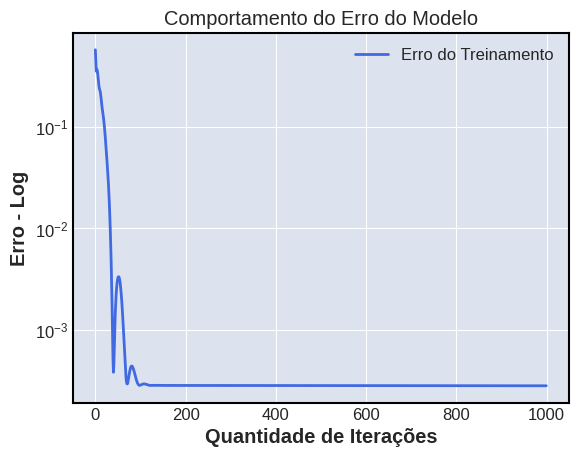

In [ ]:
iterations = range(len(loss_train))
plt.plot(iterations, loss_train, color = 'royalblue', label = 'Erro do Treinamento')
# plt.plot(iterations, loss_val, color = 'indianred',   label = 'Erro da Validação')
plt.yscale('log')
plt.legend()
plt.title('Comportamento do Erro do Modelo')
plt.ylabel('Erro - Log')
plt.xlabel('Quantidade de Iterações')
plt.show()

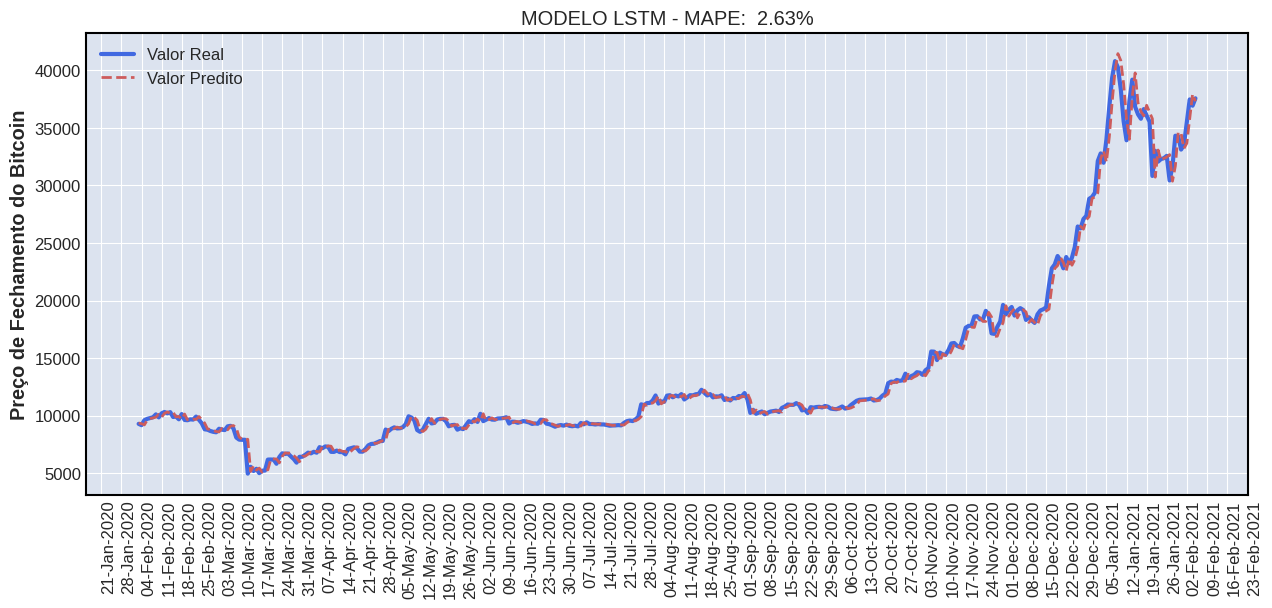

In [ ]:
plot_test(out.numpy().ravel()[train_size-1:], test_data, 'LSTM')

In [ ]:
pred_lstm = out.numpy().ravel()[train_size-1:].copy()

Conclusões:

Uma abordagem com LSTM com somente um treino foi capaz de produzir um modelo com um MAPE de 2.63% contra 2.61% do modelo ARIMA com retreino. Ao final do estudo outras métricas serão analisadas para determinar de fato qual seria a melhor abordagem para ser aplicada em 2020.

Terceira Abordagem: Hidden Markov Models (HMM)

Log Retornos $$x_l = log(x_t) - log(x_{t-1})$$

In [ ]:
log_returns = pd.DataFrame(columns = df.columns, index=df.index)
for col in df.columns:
    if col == 'Volume':
        log_returns[col] = df[col]
    else:
        log_returns[col] = np.log(df[col]) - np.log(df[col].shift(1))
log_returns.dropna(inplace = True)

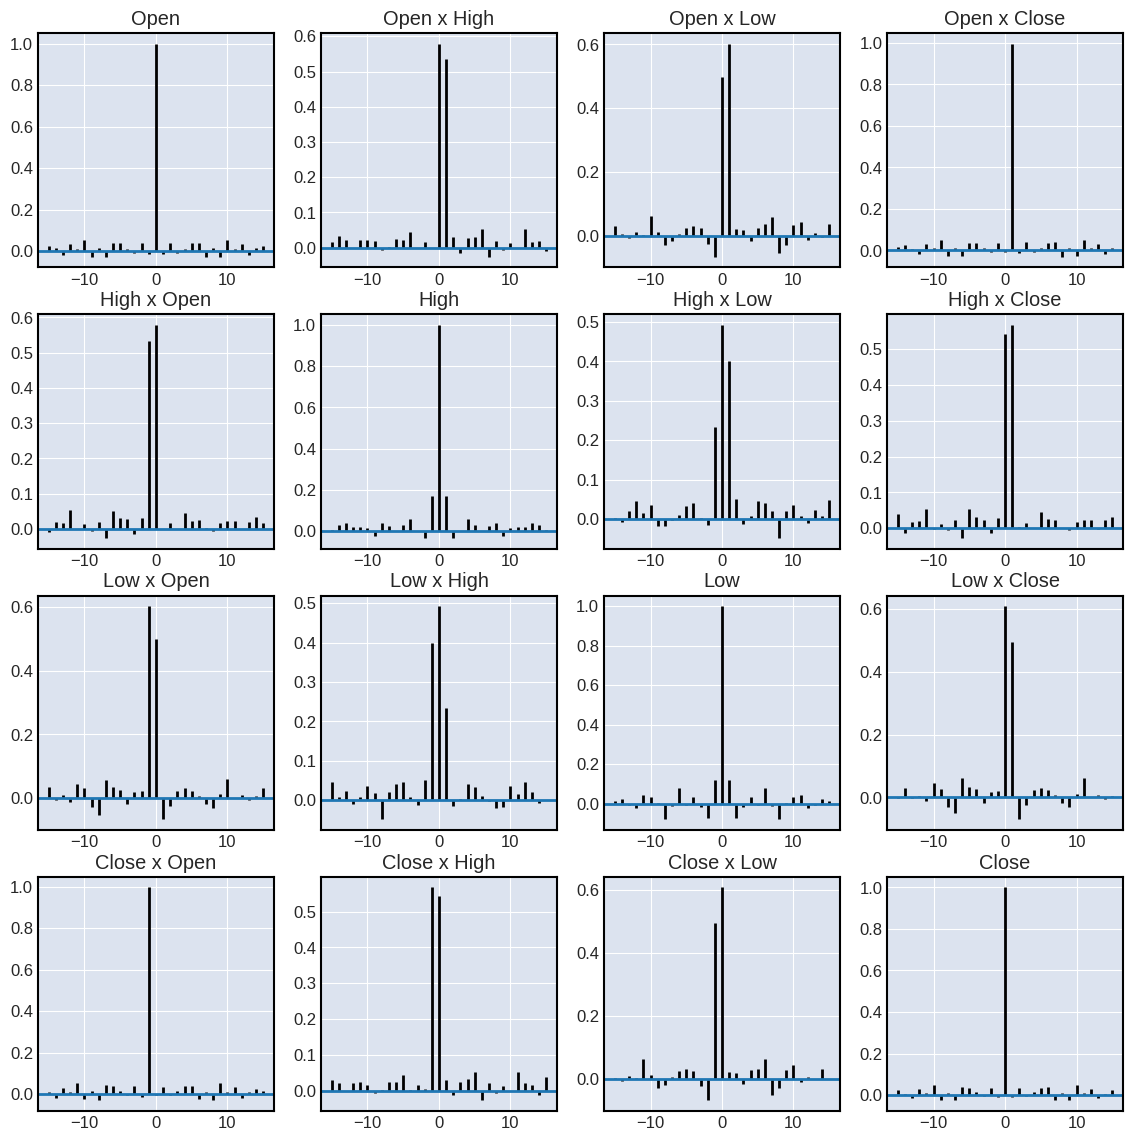

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (14,14))
for i, coli in enumerate(log_returns.columns[:-1]):
    for j, colj in enumerate(log_returns.columns[:-1]):
        if coli == colj:
            ax[i][j].acorr(log_returns[coli], maxlags=15)
            ax[i][j].set(title = coli)
        else:
            ax[i][j].xcorr(log_returns[coli], log_returns[colj], maxlags=15)
            ax[i][j].set(title = f'{coli} x {colj}')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


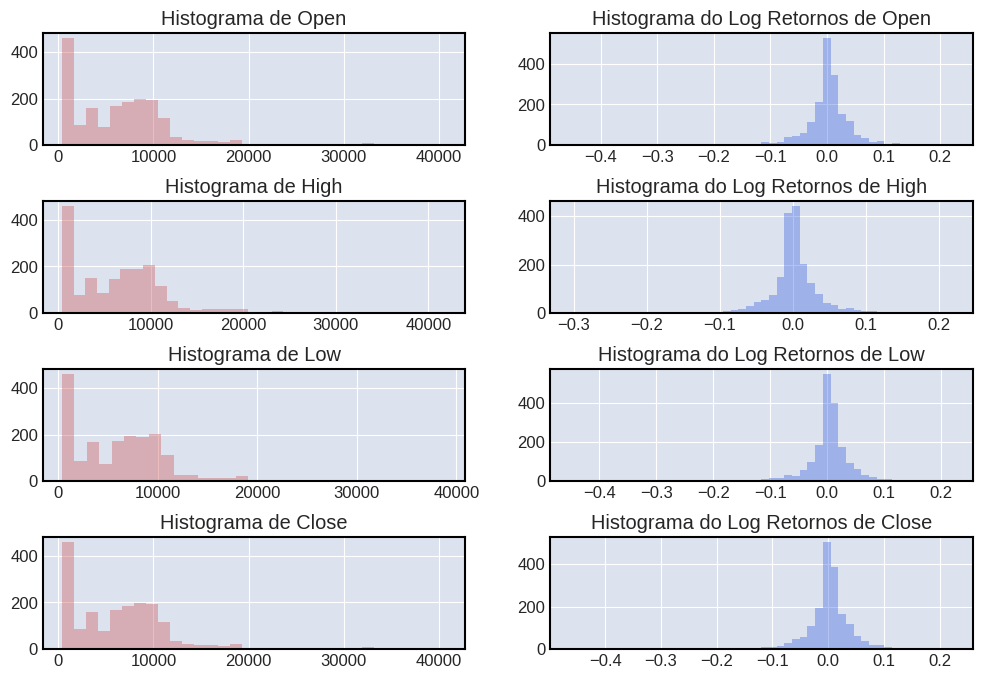

In [ ]:
fig, ax = plt.subplots(4,2, figsize = (12, 8))
plt.subplots_adjust(hspace = 0.5)
for i, col in enumerate(df.columns[:-1]):
    sns.distplot(df[col].values, kde = False, color = 'indianred', ax = ax[i][0])
    ax[i][0].set(title = f'Histograma de {col}')
    sns.distplot(log_returns[col].values, kde = False, color = 'royalblue', ax = ax[i][1])
    ax[i][1].set(title = f'Histograma do Log Retornos de {col}')
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
vals = []
for col in df.columns[:-1]:
    val0 = acorr_ljungbox(df[col].values.ravel(), lags=1)
    val1 = acorr_ljungbox(log_returns[col].values.ravel(), lags=1)
    vals.append([val0[1][0], val1[1][0]])
pd.DataFrame(vals, columns = ['Dados Brutos', 'Log Retornos'], index = df.columns[:-1])

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


,Dados Brutos,Log Retornos
Open,0.0,4.638908e-01
High,0.0,1.802855e-12
Low,0.0,7.564956e-07
Close,0.0,5.104280e-01


In [ ]:
import sys
sys.path.append(path)

In [ ]:
from hmm_BTC_price import *

In [ ]:
Sp = log_returns.copy()
T1 = Sp.shape[0]
K = 4 #number of observation data                  
y = Sp.values
#Set up training window	
WD = 365
T2 = T1-WD
AIC_log = np.empty((4,WD))
AIC_log[:] = np.nan
BIC_log = np.empty((4,WD))
BIC_log[:] = np.nan
for N in range(2, 6):
    for l in range(WD):
        x = np.empty((K,WD))
        x[:] = np.nan
        # Training data of length WD
        x = y[(T2-WD+l):(T2+l),0:K].T
        #first step using initial parameters		
        if l == 0:
            Par = hmm_iniNdata(x,N)
            mean = Par.get('mean')
            sigma = Par.get('sigma')
            A = Par.get('A')
            p = Par.get('p')
            k = BW_NdataNew(x, A, p, mean, sigma, WD, K, N)
        # after first step using HMM parameters from previous step
        else:
            A = k.get('A')
            k = BW_NdataNew(x, A, k.get('p'), k.get('mean'), k.get('sigma'), WD, K, N)
            # calculate AIC
        b = N*N + 2*N-1
        AIC_log[(N-2), l] =-2*k.get('LL') + 2*b
        BIC_log[(N-2), l] =-2*k.get('LL') + b*np.log(WD)

/content/MyDrive/My Drive/Bitcoin Forecast/hmm_BTC_price.py:112: RuntimeWarning: divide by zero encountered in log
  log_phi = np.where(phi == 0, np.log(0.0001), np.log(phi))


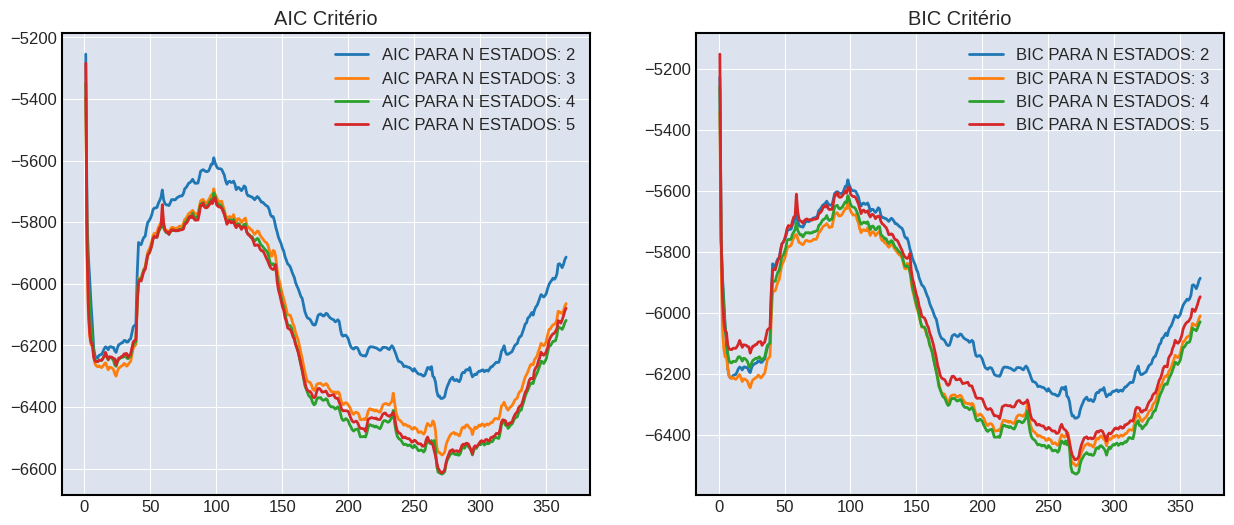

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
for N in range(4):
    aic = AIC_log[N, :]
    bic = BIC_log[N, :]
    x = list(range(1, 1+len(aic)))
    ax[0].plot(x, aic, label = f'AIC PARA N ESTADOS: {N+2}')
    ax[1].plot(x, bic, label = f'BIC PARA N ESTADOS: {N+2}')
ax[0].set(title = 'AIC Critério')
ax[1].set(title = 'BIC Critério')
ax[0].legend()
ax[1].legend()
plt.show()

/content/MyDrive/My Drive/Bitcoin Forecast/hmm_BTC_price.py:112: RuntimeWarning: divide by zero encountered in log
  log_phi = np.where(phi == 0, np.log(0.0001), np.log(phi))


Start date
2020-02-05 00:00:00
End date
2021-02-05 00:00:00


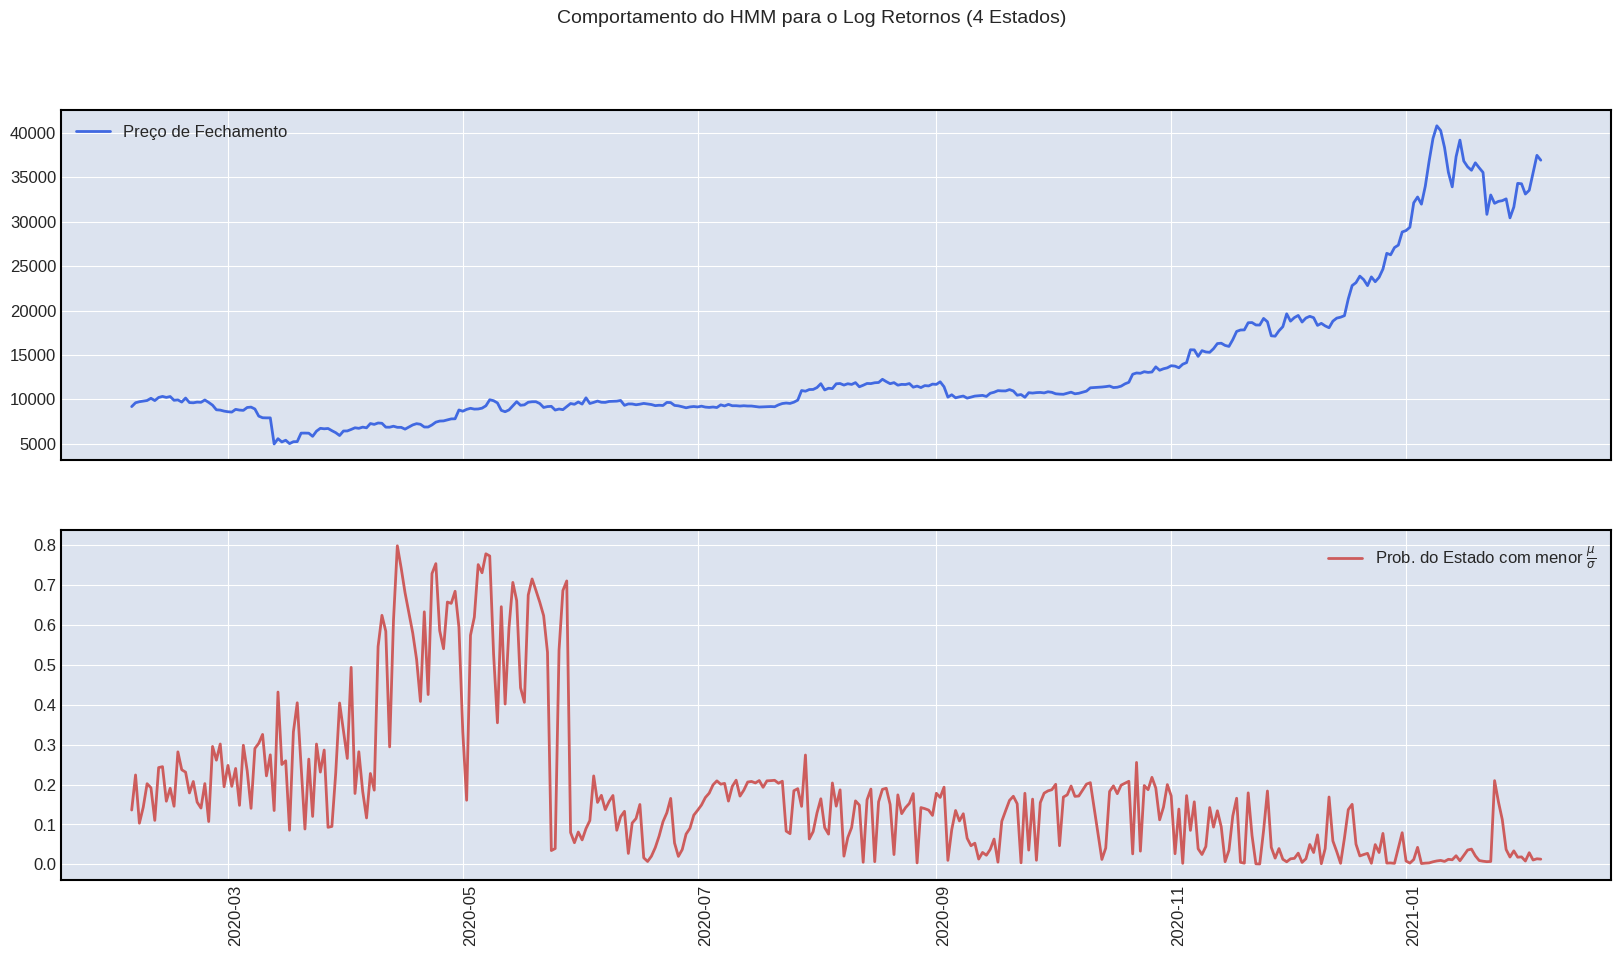

In [ ]:
Sp = log_returns.copy()
WD = 365
D = Sp.shape[0] - WD
K = 4
N = 4
Pstate2 = np.zeros((WD,))
for i in range(WD):
    y = Sp.values[(D-WD+i):(D+i),0:K].T
    T = WD
    if i == 0:
        Par = hmm_iniNdata(y,N)
        A = Par.get('A')
        p = Par.get('p')
        mean = Par.get('mean')
        sigma = Par.get('sigma')
        k = BW_NdataNew(y, A, p, mean, sigma, T,K,N)
    else:
        A = k.get('A')
        p = k.get('p')
        mean = k.get('mean')
        sigma = k.get('sigma')
        k = BW_NdataNew(y, A, p, mean, sigma, T,K,N)
    mean = k.get('mean')
    sigma = k.get('sigma')
    confiability = mean[-1,:]/sigma[-1,:]
    most_conf = np.argmin(confiability)
    u = k.get('u')
    Pstate2[i] = u[T-1,most_conf]
print("Start date")
print(Sp.index[D+2])
print("End date")
print(Sp.index[-1])

y11 = df['Close'][(D+2):(D+WD)].values.ravel()
time = Sp.index[(D+2):(D+WD)]
fig, ax = plt.subplots(2,1, figsize = (20, 10), sharex=True)
ax[0].plot(time, y11, color="royalblue", label = "Preço de Fechamento")
ax[1].plot(time,Pstate2[1:(WD-1)], color = "indianred", label= r"Prob. do Estado com menor $\frac{\mu}{\sigma}$")
ax[0].legend()
ax[1].legend()
fig.suptitle('Comportamento do HMM para o Log Retornos (4 Estados)', fontsize=14)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
# date_form = DateFormatter("%d-%b-%Y")
# ax[1].xaxis.set_major_formatter(date_form)
# ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.show()

/content/MyDrive/My Drive/Bitcoin Forecast/hmm_BTC_price.py:112: RuntimeWarning: divide by zero encountered in log
  log_phi = np.where(phi == 0, np.log(0.0001), np.log(phi))


Start date
2020-02-03 00:00:00
End date
2021-02-05 00:00:00
Error is:  1.50%


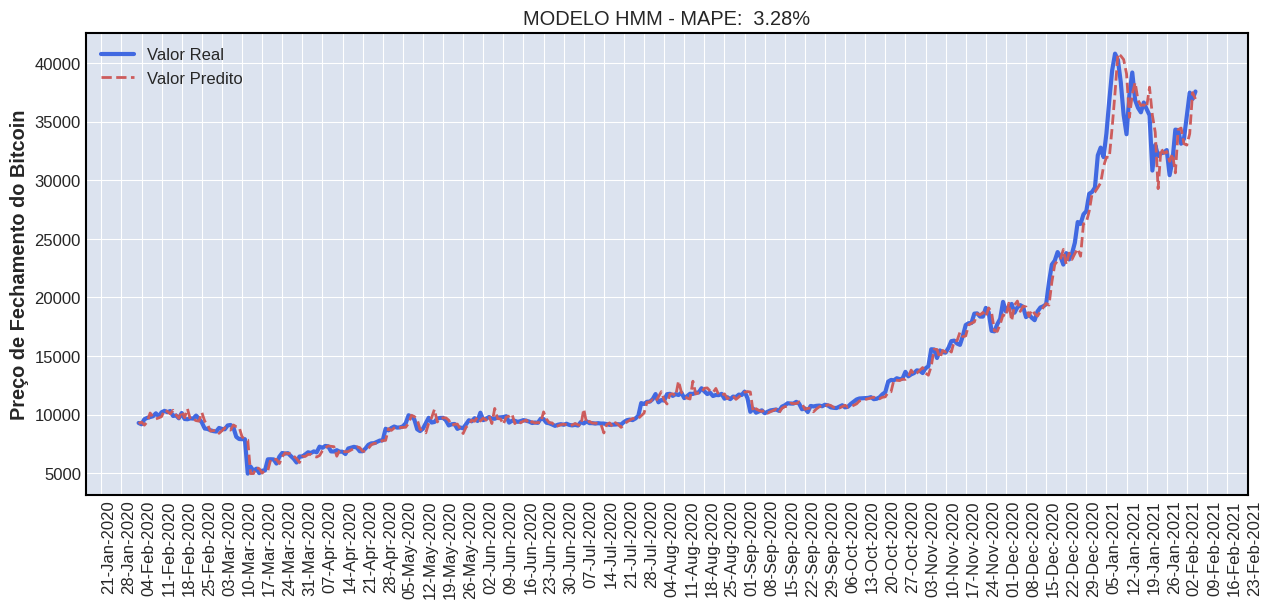

In [ ]:
Sp = log_returns.copy()
T1 = Sp.shape[0]
K = 4   #number of observation data
N = 4 #number of states
y = Sp.values
#Set up window
WD = 365
T2 = T1-WD-1
T = WD
price = np.zeros((WD,))
for l in range(WD):
    # Training data
    x = y[(T2-WD+l):(T2+l),0:K].T
    #first step using initial parameters
    if l== 0:
        Par = hmm_iniNdata(x,N)
        mean = Par.get('mean')
        sigma = Par.get('sigma')
        A = Par.get('A')
        p = Par.get('p')
        k = BW_NdataNew(x, A, p, mean, sigma, WD, K, N)
    # after first step using HMM parameters from previous step
    else:
        A = k.get('A')
        k = BW_NdataNew(x, A, k.get('p'), k.get('mean'), k.get('sigma'), WD, K, N)
    # finding the most similar (log likelihood) date in the past
    ll = np.zeros((WD,))
    for i in range(WD):
        for j in range(K):
            # z = y[(T2-WD-i+l):(T2-i+l)][j]
            z = y[(T2-WD-i+l):(T2-i+l), j]
            A = k.get('A')
            p = k.get('p')
            mean = k.get('mean')
            sigma = k.get('sigma')
            f = forward(z, A, p, mean[j,:], sigma[j,:])
            ll[i] = ll[i] + f
    Log_likelihood = k.get('LL')
    Log_likelihood = Log_likelihood*np.ones(ll.shape)
    point = np.argmin(np.abs(ll-Log_likelihood))
    # price[l] = y[(T2+l)][3] + (y[(T2-point+l)][3] - y[(T2-point+l-1)][3])
    price[l] = y[(T2-point+l)][3]
#Print results
print("Start date")
print(Sp.index[(T2+1)])
print("End date")
print(Sp.index[-1])
#calculate error
real_log = Sp['Close'][T2+1:T1].values.ravel()
pred_hmm = np.exp(np.log(df['Close'][T2:T1-1].values.ravel()) + price)
real_price = df['Close'][T2+1:T1].values.ravel()
rp = df['Close'][T2+1:T1]
time = Sp.index[T2+1:T1]
# MAPE = np.mean(np.abs(pred-real_price)/np.abs(real_price))
MAPE = mape(real_price, pred_hmm)
print(f"Error is: {MAPE: .2%}")
#Plot results
# fig, ax = plt.subplots(figsize = (20, 10))
# ax.plot(time, real_price, color = 'royalblue', label = 'True Price')
# ax.plot(time, pred_hmm, color = 'indianred', ls = '-.', label = 'Preditic Price')
# date_form = DateFormatter("%d-%b-%Y")
# ax.xaxis.set_major_formatter(date_form)
# # mdates.DayLocator
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
# plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
# ax.set_title(f'Comportamento do Preço de Fechamento Real e Predito ao Longo do Tempo Log Retornos - MAPE: {MAPE: .2%}')
# ax.legend()
# plt.show()
plot_test(pred_hmm, rp, 'HMM')

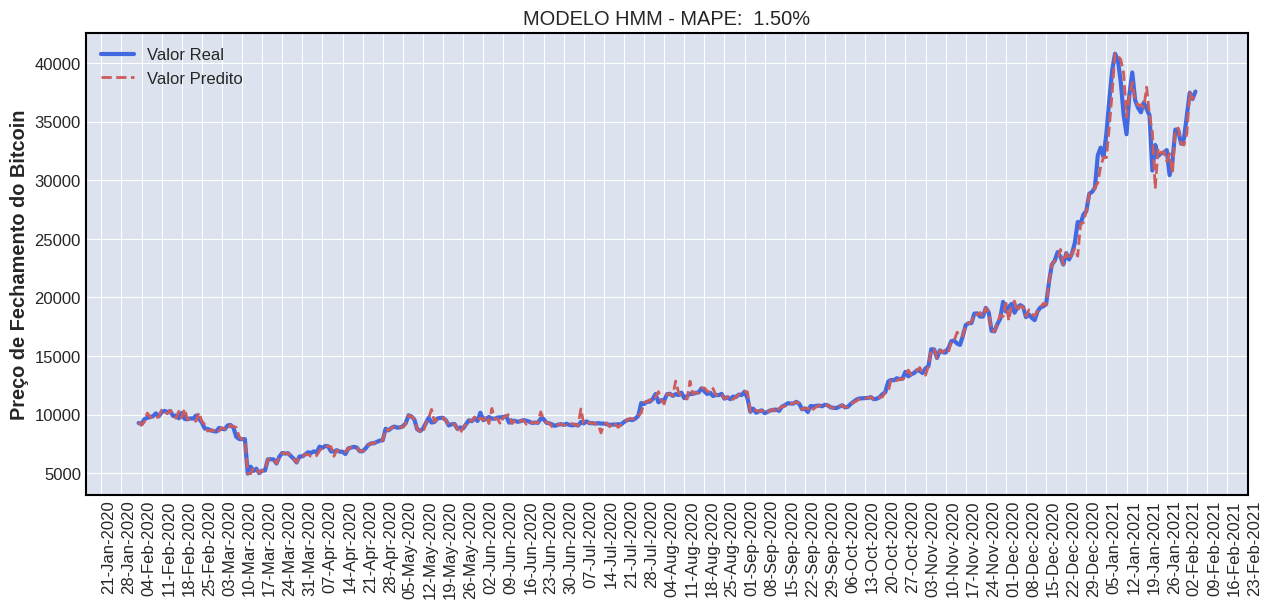

In [ ]:
#Grafico correto
pred_hmm_comp = np.append(pred_hmm[1:], df['Close'][-1])
plot_test(pred_hmm_comp, test_data, 'HMM')

Coeficiente U de Theil:
$$ U = \sqrt{\frac{\sum_{i=1}^{N} (real_i - pred_i)^2}{\sum_{i=1}^{N} (real_i - real_{i-1})^2}}$$

Se o valor de $U > 1$ então uma previsão ingênua seria melhor que o modelo. Quanto menor o valor de $U$ melhor o modelo.

In [ ]:
def coeficient_u_theil(y_true, y_pred):
  increase = np.sum(np.diff(y_true)**2)
  y_true = y_true[1:]
  rse = np.sum((y_true - y_pred)**2)
  return np.sqrt(rse/increase)

In [ ]:
dados_modelo = pd.DataFrame(test_data)
dados_modelo.rename(columns={'Close':'Preço de Fechamento Real'}, inplace = True)
dados_modelo['ARIMA Sem Retreino'] = pred_without_retrain.values.ravel()
dados_modelo['ARIMA Com Retreino'] = predictions_arima
dados_modelo['LSTM'] = pred_lstm
dados_modelo['HMM'] = pred_hmm_comp
dados_modelo.sample(5)

,Preço de Fechamento Real,ARIMA Sem Retreino,ARIMA Com Retreino,LSTM,HMM
Date,,,,,
2020-09-26,10754.437500,9331.368338,10685.452518,10700.878906,10669.249225
2020-09-16,10974.905273,9331.368338,10798.353975,10793.512695,10974.905273
2020-10-02,10585.164063,9331.368338,10619.081675,10612.853516,10585.164063
2020-05-18,9726.575195,9331.368338,9671.712450,9685.088867,9726.575195
2020-05-09,9593.896484,9331.368338,9827.660245,9858.904297,9593.896484


In [ ]:
dados_modelo.to_excel('Modelos_Previsao_Bitcoin.xlsx')

In [ ]:
cols = ['Date','Preço de Fechamento Real', 'ARIMA Sem Retreino', 'ARIMA Com Retreino', 'LSTM', 'HMM']
dados_modelo = pd.read_excel('Modelos_Previsao_Bitcoin.xlsx', parse_dates=['Date'], index_col='Date', usecols=cols)
dados_modelo.sample(5)

,Preço de Fechamento Real,ARIMA Sem Retreino,ARIMA Com Retreino,LSTM,HMM
Date,,,,,
2020-05-17,9670.739258,9331.368338,9387.212198,9391.967773,9670.739258
2020-04-30,8658.553711,9331.368338,8829.702651,8821.938477,8658.553711
2020-02-23,9924.515625,9331.356376,9685.419557,9676.636719,9448.128149
2021-01-17,35791.277344,9331.368338,36252.576657,36431.339844,36433.618947
2020-07-07,9252.277344,9331.368338,9382.375557,9393.694336,9252.277344


In [ ]:
def trading_strategy(forescat_value):
  valor_inicial = df.loc['2020-02-02', 'Close']
  preco = 'Preço de Fechamento Real'
  prev = forescat_value.values.ravel()
  prev = np.insert(prev, 0, valor_inicial, axis=0)
  diference = np.diff(prev)
  analise = ['-' for i in range(dados_modelo.shape[0])]
  retorno_op = 0
  for i in range(dados_modelo.shape[0]):
    if i > 0:
      if diference[i] >= 0:
        analise[i] = 'Compra'
        retorno_op += dados_modelo.iloc[i][preco] - dados_modelo.iloc[i-1][preco]
      else:
        analise[i] = 'Venda'
    else:
      if diference[i] >= 0:
        analise[i] = 'Compra'
        retorno_op += dados_modelo.iloc[i][preco] - valor_inicial
      else:
        analise[i] = 'Venda'
  return retorno_op, analise

In [ ]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
col_real = dados_modelo.columns[0]
results = {}
operations = {}
for col in dados_modelo.columns[1:]:
  cut = coeficient_u_theil(df.loc['2020-02-02':, 'Close'].values.ravel(), dados_modelo[col].values.ravel())
  rmse = mean_squared_error(dados_modelo[col_real], dados_modelo[col], squared = False)
  log_error = mean_squared_log_error(dados_modelo[col_real], dados_modelo[col])
  MAPE = mape(dados_modelo[col_real], dados_modelo[col])*100
  retorno_inv, operacoes = trading_strategy(dados_modelo[col])
  results[col] = {'U Theil': cut, 'RMSE': rmse, 'Erro Logarítmico': log_error, 'MAPE': MAPE, 'Retorno do Investimento': retorno_inv}
  operations[col] = operacoes
pd.DataFrame(results)

,ARIMA Sem Retreino,ARIMA Com Retreino,LSTM,HMM
U Theil,13.367146,1.011164,1.034919,0.800678
RMSE,9322.358602,705.194251,721.761034,558.399351
Erro Logarítmico,0.291726,0.001897,0.001856,0.000841
MAPE,26.989629,2.606862,2.634790,1.500568
Retorno do Investimento,32271.581055,21144.714360,21595.435551,52402.168456


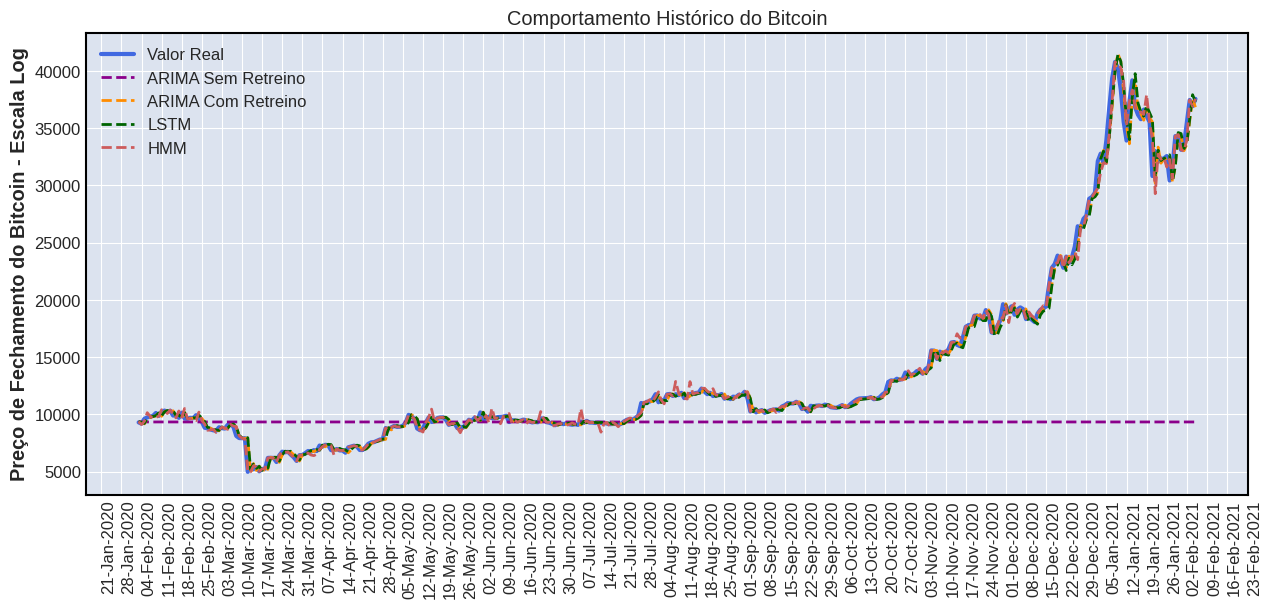

In [ ]:
colors_model = {'ARIMA Sem Retreino': 'darkmagenta', 'ARIMA Com Retreino': 'darkorange', 'LSTM': 'darkgreen', 'HMM': 'indianred'}
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(dados_modelo[col_real], color = 'royalblue', lw = 3, label = 'Valor Real')
for col in dados_modelo.columns[1:]:
  ax.plot(dados_modelo[col], color = colors_model[col], ls = '--', label = col)
ax.set_title(f'Comportamento Histórico do Bitcoin')
date_form = DateFormatter("%d-%b-%Y")
date_form = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_ylabel('Preço de Fechamento do Bitcoin - Escala Log')
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
# ax.set_yscale('log')
ax.legend()
plt.show()

In [ ]:
from scipy.stats import shapiro
amount_tests = 500000
for col in dados_modelo.columns[1:]:
  residual = dados_modelo['Preço de Fechamento Real'] - dados_modelo[col]
  p_val = []
  for _ in range(amount_tests):
    sh, pvalor = shapiro(residual.sample(30).values.ravel())
    p_val.append(pvalor)
  beta = np.std(p_val)*100/(np.mean(p_val)*np.sqrt(amount_tests))
  med = np.mean(p_val)
  print(f'P Valor: {med} - Erro Padrão Relativo: {beta}')

P Valor: 0.000256567559051141 - Erro Padrão Relativo: 3.480684179669847
P Valor: 0.0265990168098378 - Erro Padrão Relativo: 0.5577875133366399
P Valor: 0.023175398278601586 - Erro Padrão Relativo: 0.5847773294745044
P Valor: 0.0003217096785732434 - Erro Padrão Relativo: 1.9476197579378844


In [ ]:
res = []
for col in dados_modelo.columns[2:]:
  residual = dados_modelo['Preço de Fechamento Real'] - dados_modelo[col]
  res.append(residual.values.ravel())

In [ ]:
from scipy.stats import kruskal
kruskal(*res)

KruskalResult(statistic=5.980210016838216, pvalue=0.05028215639660479)